Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC2433 - Minería de Datos <br>
Primer Semestre 2025
<br>
<h1><center>Vicente Lavagnino </center></h1>
<h1><center>Tarea 2: Isolation Forest, HAC, DBSCAN y HDBSCAN </center></h1>
        Profesor: Marcelo Mendoza<br>
        Ayudantes encargados: Itzae Flores, Claudia González y Eduardo Salinas.<br>
        Fecha de entrega: 23 de abril del 2025.

## Indicaciones

Deberás entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se te dará puntaje tanto por código como por la manera en la que respondas las preguntas planteadas.
- El notebook debe tener todas las celdas de código ejecutadas.
- El carácter de esta tarea es **INDIVIDUAL**. Cualquier instancia de copia resultará en un 1,1 como nota de curso.

---

## Librerías

In [36]:
##Importa acá las librerias que vayas a utilizar
## De ser necesario, utiliza el comando !pip install a aquellas librerias o modulos que no se encuentren instalados, como puede ser HDBSCAN.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from random import random
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, minmax_scale
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN, cluster_optics_dbscan
from sklearn.ensemble import IsolationForest
from sklearn.cluster import  HDBSCAN
from sklearn.mixture import GaussianMixture


El siguiente codigo sirve para importar HDBSCAN en el caso de que les arroje error importar desde sklearn.

In [34]:
from hdbscan import HDBSCAN

# Introducción

El conjunto de datos corresponde a características extraidas de imagenes de distintos clientes que están buscando pedir un crédito a un banco. Se trabaja con este dataset para predecir si el cliente aceptó o no el último préstamo ofrecido (dado por la columna "Personal Loan") por medio del uso de HAC, DBSCAN, HDBSCAN e Isolation Forest.

En esta tarea deberás trabajar con el dataset Imbalanced Personal Bank Loan Classification que puedes descargar de [Kaggle] (https://www.kaggle.com/code/farzadnekouei/imbalanced-personal-bank-loan-classification) o Canvas.

# Parte 1: Carga y Preprocesamiento de Datos (9 puntos)

En esta primera parte se debe cargar el dataset y luego describir el comportamiento de algunas variables de interés. Posteriormente, debe realizar el proceso de normalización de los datos.

### 1.1 Carga de datos (1 puntos)

In [4]:
df = pd.read_csv('data.csv')
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


### 1.2 Descripcion del Dataset (5 puntos)

#### 1.2.1 Describa brevemente cuantas columnas tiene el dataset y en que consisten las columna del dataset entregado (1 puntos)

In [5]:
# Descripción de las columnas:

for column in df.columns:
    print(f"{column}: {df[column].dtype}")
    print(df[column].describe())
    print("\n")


ID: int64
count    5000.000000
mean     2500.500000
std      1443.520003
min         1.000000
25%      1250.750000
50%      2500.500000
75%      3750.250000
max      5000.000000
Name: ID, dtype: float64


Age: int64
count    5000.000000
mean       45.338400
std        11.463166
min        23.000000
25%        35.000000
50%        45.000000
75%        55.000000
max        67.000000
Name: Age, dtype: float64


Experience: int64
count    5000.000000
mean       20.104600
std        11.467954
min        -3.000000
25%        10.000000
50%        20.000000
75%        30.000000
max        43.000000
Name: Experience, dtype: float64


Income: int64
count    5000.000000
mean       73.774200
std        46.033729
min         8.000000
25%        39.000000
50%        64.000000
75%        98.000000
max       224.000000
Name: Income, dtype: float64


ZIP Code: int64
count     5000.000000
mean     93152.503000
std       2121.852197
min       9307.000000
25%      91911.000000
50%      93437.000000
75%   

**Respuesta:**
Vemos que el dataset tiene 14 columnas y 5000 filas.
De estas columnas vemos que existen variables asociadas a información personal y demográficas del cliente y variables binarias que indican la poseencia de ciertos productos o características financieras, además de esto tenemos la variable ID que actualmente sirve como identificador único de cada cliente por lo que no aporta información relevante para el análisis.

En el código anterior también vimos que ciertos indicadores relevantes a tener en cuenta como se distribuyen estos datos, sus valores mínimos, máximos, medias, etc.

#### 1.2.2 ¿Es posible en este dataset eliminar columnas sin afectar de manera significativa los datos? ¿Por qué? (2 puntos)

In [6]:
# Drop ID y ZIP Code
df = df.drop(columns=['ID', 'ZIP Code'])
df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


**Respuesta:**

En primer lugar podemos asumir que la columna ID la podemos eliminar ya no debería afectar al análisis de dataset debido a que es un dato de identificación que no aporta información adicional.

Por otro lado, la variable ZIP Code es tomada como una variable numérica, sin embargo, no es una variable numérica, sino que es una variable categórica que indica el código postal del cliente. Por lo que no aporta información relevante para el análisis y podemos eliminarla, podríamos  eventualmente agregarla posteriormente si es que consideramos que esta información es relevante para el análisis pero de todas maneras requiere de un tratamiento previo para poder ser utilizada.

Luego, dependiendo de los objetivos del análisis podemos determinar que columnas podemos eliminar según la varianza y cantidad de datos que existen, sin embargo por ahora no eliminaremos ninguna otra variable.



#### 1.2.3 ¿Por qué crees que es relevante trabajar estos datos? Averigua 3 posibles usos en que trabajar los datos de esta forma podría ser útil para problemas que resuelven las organizaciones (2 puntos)

**Respuesta:**

Estos datos son importantes de trabajar ya que permiten a las instituciones bancarias tomar decisiones con mayor información respecto a la segmentación de clientes para estrategias personalizadas, identificación de anomalías o comportamientos atípicos y predicción de aceptación de préstamos.

Entrando más en detalle con cada punto lo podemos ver como:

1. Segmentación de clientes para estrategias personalizadas:
A través de técnicas de agrupamiento como HAC o DBSCAN, el banco puede clasificar a sus clientes en distintos segmentos según variables como edad, ingreso, nivel de educación, uso de productos financieros, entre otros. Esto permite ofrecer productos adaptados a cada grupo, optimizando las campañas comerciales y mejorando la tasa de aceptación de los préstamos.

2.	Identificación de anomalías o comportamientos atípicos:
Utilizando algoritmos como HDBSCAN o Isolation Forest, se pueden detectar clientes que presentan patrones significativamente diferentes al resto, lo cual puede ser útil para alertar sobre posibles fraudes, errores en los datos o identificar perfiles poco comunes que requieran análisis más detallado.

3.	Predicción de aceptación de préstamos:
Analizando los patrones históricos, es posible entrenar modelos que anticipen la probabilidad de que un nuevo cliente acepte un préstamo o no pueda pagarlo, esto ayuda a focalizar campañas y acelerar procesos de estimación de riesgo.

### 1.3 Determinación de valores nulos (1 punto)

Determina si existen datos y/o valores nulos presentes en el dataset. En caso de que existan, realiza el tratamiento pertinente.

In [7]:
# Determinar datos y/o valores nulos
print(df.isnull().sum())

Age                   0
Experience            0
Income                0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64


**Respuesta:**
Vemos que ninguna de las columnas tiene datos nulos, por lo que no es necesario realizar ningún tratamiento.

### 1.4 Manejo del Dataset (2 puntos)

Normaliza los valores de las columnas del dataset. ¿Por qué esto es importante para el análisis?

In [8]:
# Normalizamos solo las columnas numéricas ya que las categóricas ya están en 0 y 1.
numericas = ['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage']
categoricas = ['Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']

scaler = preprocessing.MinMaxScaler()
df[numericas] = scaler.fit_transform(df[numericas])


print("Dataset normalizado:")
df.head()



Dataset normalizado:


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,0.045455,0.086957,0.189815,1.000000,0.16,0.0,0.0,0,1,0,0,0
1,0.500000,0.478261,0.120370,0.666667,0.15,0.0,0.0,0,1,0,0,0
2,0.363636,0.391304,0.013889,0.000000,0.10,0.0,0.0,0,0,0,0,0
3,0.272727,0.260870,0.425926,0.000000,0.27,0.5,0.0,0,0,0,0,0
4,0.272727,0.239130,0.171296,1.000000,0.10,0.5,0.0,0,0,0,0,1


**Respuesta**
Normalizamos las columnas numéricas para que tengan un rango de valores entre 0 y 1 con MinMaxScaler.
Esto es importante para un análisis posterior ya que asegura que todas las variables estén en la misma escala.

Esto es necesario ya que al usar HAC, DBSCAN, HDBSCAN e Isolation Forest, estamos usando técnicas de distancia para agrupar datos, y si las variables no están normalizadas, las que tengan valores más altos dominarán el análisis, castigando a las variables con valores más bajos.

# Parte 2: Isolation Forest (15 puntos)

### 2.1 Reduzca la cantidad de componente reteniendo el 95% de la varianza (1 punto)

In [9]:
# Separar features (X) y target (y)
X = df.drop('Personal Loan', axis=1)  # Excluimos Personal Loan
y = df['Personal Loan']  # Guardamos Personal Loan como target

# X = df.copy() # Si no excluimos la variable Personal Loan

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

print(X_pca.shape)

(5000, 8)


**Respuesta:**
Vemos que al reducir las componentes a 0.95 de varianza, obtenemos 8 componentes principales que representan el 95% de la varianza total del dataset.

Además, excluimos la variable Personal Loan ya que es nuestra variable objetivo "y" y no debería ser incluida en las características x que usamos para entrenar el modelo.

### 2.2 Utilizando 100 iTrees, cree una instancia de Isolation Forest. ¿Cuántos outliers detecta Isolation Forest y a qué clases verdaderas pertenecen? (3 puntos)

In [10]:
# Crear instancia de Isolation Forest
iforest = IsolationForest(n_estimators=100, random_state=42)
iforest.fit(X_pca) # Entrenar el modelo
outliers = iforest.predict(X_pca) # Predecir outliers

# Calcular el numero de outliers
n_outliers = (outliers == -1).sum()
n_inliers = (outliers == 1).sum()

print(f"Outliers detectados: {n_outliers}")
print(f"Inliers detectados: {n_inliers}")

Outliers detectados: 1137
Inliers detectados: 3863


In [11]:
# A que clase pertenecen los outliers
outliers_df = pd.DataFrame({'outlier': outliers, 'loan': df['Personal Loan']})

# Contar outliers por clase
outliers_by_class = outliers_df[outliers_df['outlier'] == -1]['loan'].value_counts()
total_by_class = df['Personal Loan'].value_counts()

print("Distribución de outliers por clase:")
print(outliers_by_class)

Distribución de outliers por clase:
loan
0    882
1    255
Name: count, dtype: int64


**Respuesta:** 
Al aplicar isolation forest con 100 iTrees logramos ver que existen 1137 Outliers detectados y  3863 Inliers detectados.

Al ver a que clase pertenecen, observamos que 882 outliers pertenecen a la clase 0 y 225 outliers pertenecen a la clase 1.

*Nota: en caso de que no fuese necesario excluir la variable Personal Loan, el numero de outliers detectados seria de 1160 y el numero de inliers seria de 3840, dando un total de 882 outliers para clase 0 y 225 outliers para clase 1. Desde ahora en adelante asumiremos que es necesario excluir la variable Personal Loan, pero en caso de que no fuese necesario, solo hay que descomentar la línea del ejercicio 2.1 # X = df.copy() # Si no excluimos la variable Personal Loan*


### 2.3 ¿Como cambia el numero de de outliers detectados al variar el parametro ```contamination```? Utilize los valores ```[0.01, 0.05, 0.1, 0.2]``` (3 puntos)


Contaminación: 0.01, Outliers detectados: 50
Contaminación: 0.05, Outliers detectados: 250
Contaminación: 0.1, Outliers detectados: 500
Contaminación: 0.2, Outliers detectados: 1000


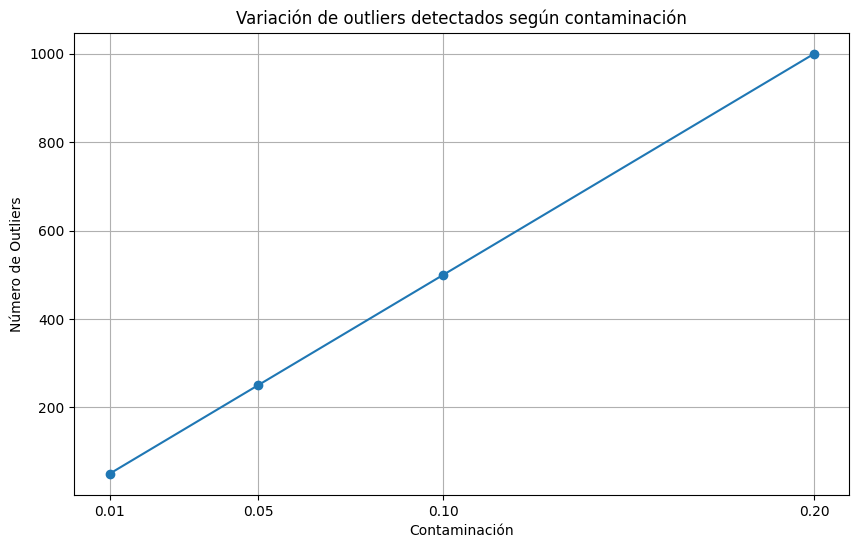

In [12]:
valores = [0.01, 0.05, 0.1, 0.2]
variacion = []

for valor in valores:
    iforest = IsolationForest(n_estimators=100, contamination=valor, random_state=42)
    iforest.fit(X_pca)
    outliers = iforest.predict(X_pca)
    n_outliers = (outliers == -1).sum()
    variacion.append([valor, n_outliers])
    print(f"Contaminación: {valor}, Outliers detectados: {n_outliers}")

# Separar los valores de x e y para el gráfico
x_valores = [v[0] for v in variacion]
y_valores = [v[1] for v in variacion]

# Graficar la variación de outliers detectados
plt.figure(figsize=(10, 6))
plt.plot(x_valores, y_valores, 'o-') 
plt.xlabel('Contaminación')
plt.ylabel('Número de Outliers')
plt.title('Variación de outliers detectados según contaminación')
plt.grid(True)  # Agregar cuadrícula
plt.xticks(x_valores)  # Mostrar todos los valores de contaminación en el eje x
plt.show()

**Respuesta:**

Vemos como al aumentar el valor de contamination, aumenta el numero de outliers detectados, donde el ascenso para esta estos parametros es lineal (Lo que no necesariamente es inferible al seguir aumentando el valor de contamination).

### 2.4 Grafique los "anomaly scores" e indique si se ve un umbral claro (2 puntos)

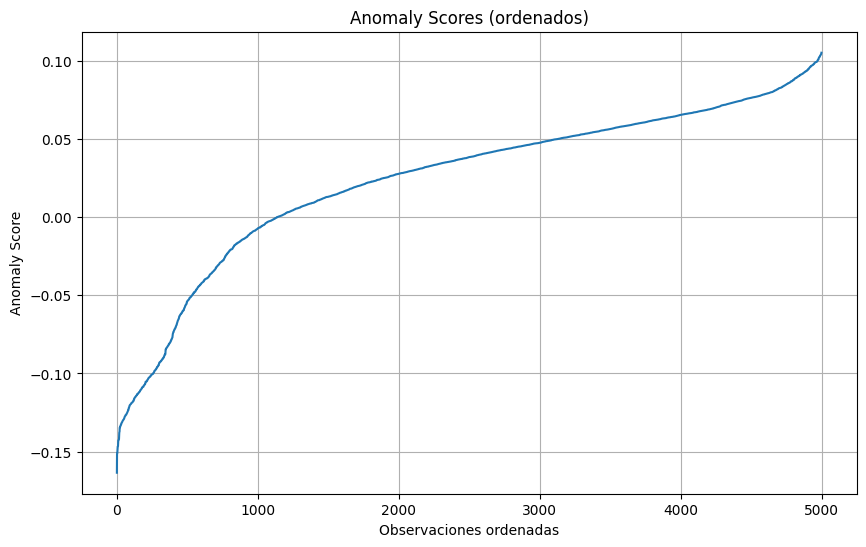

In [13]:
# Seguimos usando los valores anteriores
iforest = IsolationForest(n_estimators=100, random_state=42)
outliers = iforest.fit_predict(X_pca)

scores = iforest.decision_function(X_pca) 

# Graficar los scores
scores_sorted = np.sort(scores)

plt.figure(figsize=(10, 6))
plt.plot(scores_sorted)
plt.title('Anomaly Scores (ordenados)')
plt.xlabel('Observaciones ordenadas')
plt.ylabel('Anomaly Score')
plt.grid(True)
plt.show()


**Respuesta:**

Vemos que al graficar los anomaly scores ordenados, se observa un descenso rápido en los primeros valores del eje X, lo que indica un grupo de observaciones con scores considerablemente más bajos que el resto. Esta diferencia marca un umbral claro entre observaciones consideradas anómalas (outliers) y observaciones normales


### 2.5 Que tan estable es la detección de outliers si cambiamos la cantidad de arboles (```n_estimators```) (4 puntos)

Número de árboles: 10, Outliers detectados: 1741
Número de árboles: 50, Outliers detectados: 1182
Número de árboles: 100, Outliers detectados: 1137
Número de árboles: 200, Outliers detectados: 1199
Número de árboles: 300, Outliers detectados: 1237
Número de árboles: 400, Outliers detectados: 1221
Número de árboles: 500, Outliers detectados: 1210
Número de árboles: 1000, Outliers detectados: 1272
Número de árboles: 2000, Outliers detectados: 1281
Número de árboles: 3000, Outliers detectados: 1283
Número de árboles: 4000, Outliers detectados: 1271
Número de árboles: 5000, Outliers detectados: 1274


Text(0.5, 0, 'Número de árboles')

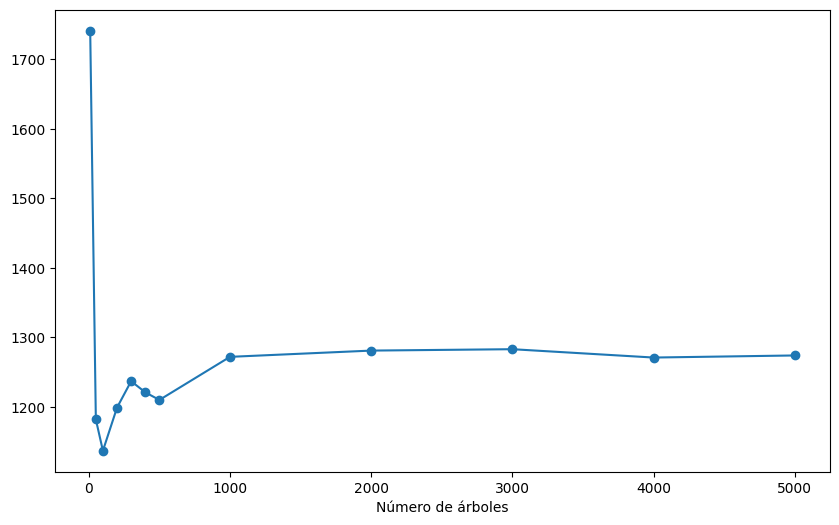

In [14]:
valores_n_estimators = [10, 50, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]
variacion_n_estimators = []

for valor in valores_n_estimators:
    iforest = IsolationForest(n_estimators=valor, random_state=42)
    iforest.fit(X_pca)
    outliers = iforest.predict(X_pca)
    n_outliers = (outliers == -1).sum()
    variacion_n_estimators.append([valor, n_outliers])
    print(f"Número de árboles: {valor}, Outliers detectados: {n_outliers}")

# Separar los valores de x e y para el gráfico
x_valores_n_estimators = [v[0] for v in variacion_n_estimators]
y_valores_n_estimators = [v[1] for v in variacion_n_estimators]

# Graficar la variación de outliers detectados
plt.figure(figsize=(10, 6))
plt.plot(x_valores_n_estimators, y_valores_n_estimators, 'o-')
plt.xlabel('Número de árboles')


**Respuesta:**

Se evaluó la estabilidad de la detección de outliers con n_estimators entre 10 y 5000 árboles. Al utilizar solo 10 árboles, el modelo detectó una cantidad mucho mayor de outliers (1741), lo que indica una alta variabilidad y poca estabilidad con valores bajos.

A partir de 100 árboles, el número de outliers detectados se estabiliza en torno a los 1250, y las variaciones entre 100 y 5000 árboles son menores. De esta manera sabemos  que el modelo se vuelve considerablemente más robusto y consistente en sus predicciones cuando n_estimators es suficientemente alto.

Además de darnos cuenta que el valor de 100 el cual ya habíamos probado anteriormente es el valor minimo para el modelo.



### 2.6 Grafique los outliers detectados en las primeras dos componentes principales. (Utilize parametro ```alpha=0.6```) (2 puntos)

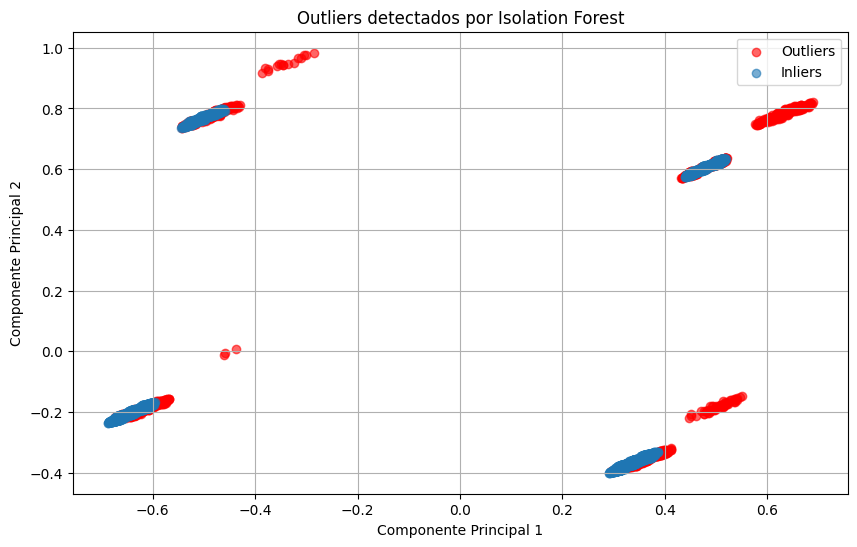

In [15]:
# Volvemos a usar el modelo con 100 arboles
iforest = IsolationForest(n_estimators=100, random_state=42)
iforest.fit(X_pca)
outliers = iforest.predict(X_pca)

# 2 primeras componentes principales
x1 = X_pca[:, 0]
x2 = X_pca[:, 1]

# Máscara para separar inliers y outliers
inliers_mask = outliers == 1
outliers_mask = outliers == -1

# Graficamos
plt.figure(figsize=(10, 6))
plt.scatter(x1[outliers_mask], x2[outliers_mask], alpha=0.6, color='red', label='Outliers')
plt.scatter(x1[inliers_mask], x2[inliers_mask], alpha=0.6, label='Inliers')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Outliers detectados por Isolation Forest')
plt.legend()
plt.grid(True)
plt.show()

**Respuesta:**

Se graficaron los outliers detectados por Isolation Forest sobre las dos primeras componentes principales obtenidas con PCA, con alpha=0.6. En el gráfico se observa que los outliers (en rojo) tienden a ubicarse en los extremos de los grupos de datos, mientras que los inliers (en azul) están más centrados.

# Parte 3: HAC (5 puntos)

### 3.1 Reliza un dendograma sin clusters y con distancia threshold igual a 0 para visualizar los datos (1 punto)

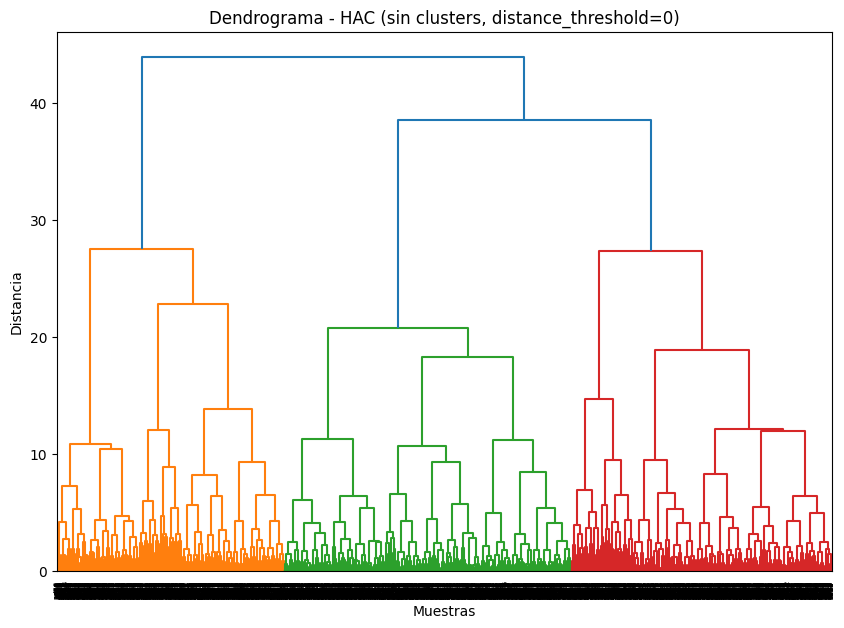

In [16]:
# dendograma sin clusters y con distancia threshold igual a 0

hac = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
hac.fit(X_pca)

# Esta función fue tomada desde  https://github.com/marcelomendoza/IIC2433/blob/main/Codes/6%20-%20HAC.ipynb 
def plot_dendrogram(model, **kwargs):

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0]) 
    n_samples = len(model.labels_) # model.labels_: cluster labels for each point
    for i, merge in enumerate(model.children_): 
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples] # in-order enumeration of nodes
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# Plot the dendrogram
plt.figure(figsize=(10, 7))
plot_dendrogram(hac)
plt.title('Dendrograma - HAC (sin clusters, distance_threshold=0)')
plt.xlabel('Muestras')
plt.ylabel('Distancia')
plt.show()

**Respuesta:**

Generamos un dendograma sin clusters y con distancia threshold igual a 0 para visualizar los datos.

### 3.2 Realiza los Clustering de Agrupación Jerarquica (HAC) para cada distancia de clustering aglomerativo (linkage), prueba utilizando número entre 2 y 10. Calcula el Silhouette para ver cual funcionó mejor y explica el por qué de los resultados. (1.5 puntos)


Linkage: single, Clusters: 2, Silhouette: 0.24499956888021562
Linkage: single, Clusters: 3, Silhouette: 0.21455296824919792
Linkage: single, Clusters: 4, Silhouette: 0.1959349119414861
Linkage: single, Clusters: 5, Silhouette: 0.2663402193763673
Linkage: single, Clusters: 6, Silhouette: 0.2625458424810094
Linkage: single, Clusters: 7, Silhouette: 0.27101450856900167
Linkage: single, Clusters: 8, Silhouette: 0.2902790988960091
Linkage: single, Clusters: 9, Silhouette: 0.2857911722365636
Linkage: single, Clusters: 10, Silhouette: 0.2941235768631681
Linkage: complete, Clusters: 2, Silhouette: 0.22906177914890585
Linkage: complete, Clusters: 3, Silhouette: 0.23298220532405475
Linkage: complete, Clusters: 4, Silhouette: 0.23882183995393574
Linkage: complete, Clusters: 5, Silhouette: 0.28014332352821275
Linkage: complete, Clusters: 6, Silhouette: 0.1946617146419696
Linkage: complete, Clusters: 7, Silhouette: 0.19333771428170554
Linkage: complete, Clusters: 8, Silhouette: 0.17320485265790525


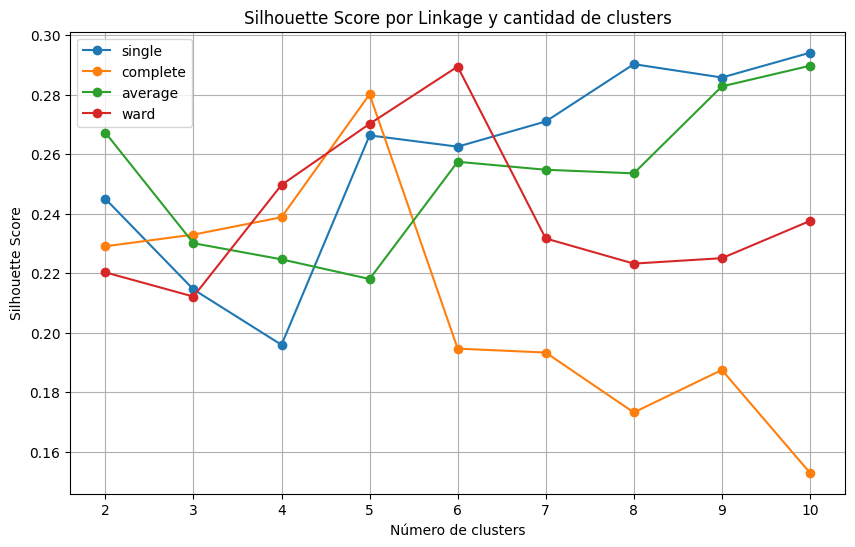

In [17]:
linkage_methods = ['single', 'complete', 'average', 'ward']
all_methods = []
all_clusters = []
all_scores = []

# Iteramos
for method in linkage_methods:
    for k in range(2, 11):
        model = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = model.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        all_methods.append(method)
        all_clusters.append(k)
        all_scores.append(score)
        print(f"Linkage: {method}, Clusters: {k}, Silhouette: {score}")

plt.figure(figsize=(10, 6))

for method in linkage_methods:
    x = [all_clusters[i] for i in range(len(all_methods)) if all_methods[i] == method]
    y = [all_scores[i] for i in range(len(all_methods)) if all_methods[i] == method]
    
    plt.plot(x, y, marker='o', label=method)

plt.title("Silhouette Score por Linkage y cantidad de clusters")
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.legend()
plt.grid(True)
plt.show()

**Respuesta:**

El mejor resultado se obtuvo con el método single usando 10 clusters, alcanzando un Silhouette Score cercano a 0.296.

Sin embargo, otros metodos como average tambien tiene un buen resultado al aumentar el numero de clusters.
Mientas que ward y complete tienen un mejor resultado con menos clusters y después caen.

### 3.3 Ahora, realiza los Clustering de Agrupación Jerarquica (HAC) para cada tipo de linkage. Calcula el Silhouette para ver cual funcionó mejor y explica el por qué de los resultados, mencionando de que manera funciona cada linkage. Usa 20 clusters (1.5 puntos)

In [18]:
scores_20_clusters = []

for method in linkage_methods:
    model = AgglomerativeClustering(n_clusters=20, linkage=method)
    labels = model.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores_20_clusters.append((method, score))
    print(f"Linkage: {method}, Silhouette: {score}")

Linkage: single, Silhouette: 0.2864959190003835
Linkage: complete, Silhouette: 0.16033191584828468
Linkage: average, Silhouette: 0.28008998127381063
Linkage: ward, Silhouette: 0.2235840655318938


**Respuesta:**

El mejor resultado se obtuvo con el método single usando 20 clusters, alcanzando un Silhouette Score cercano a 0.286.

Este resultado puede explicarse ya que en primer lugar los datos ya estaban normalizados, lo que indica que los puntos ya estan suficientemente cercanos entre si, por lo que el metodo single es el que mejor funciona.



### 3.4 Grafica los clusters utilizando un PCA de 2 dimensiones de los datos. Usa 20 clusters y el linkage con mejor silhouette score (1 punto)






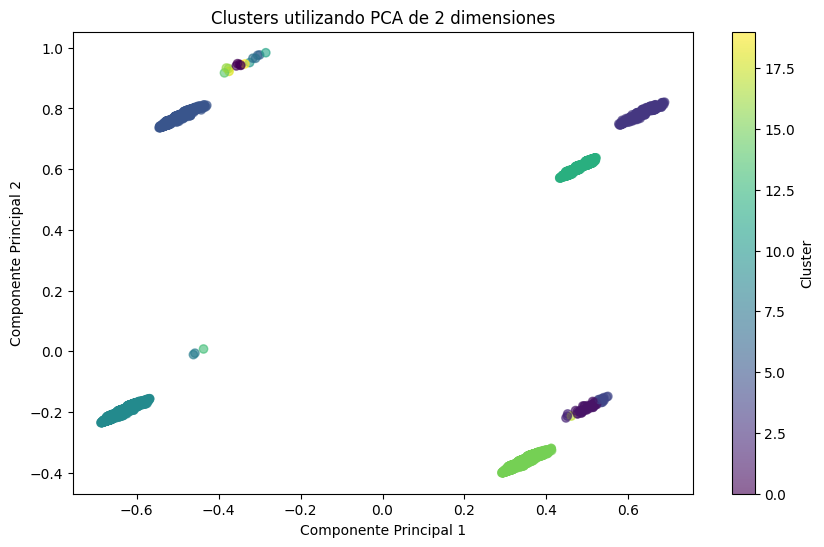

In [ ]:
# linkage single con 20 clusters

pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

model = AgglomerativeClustering(n_clusters=20, linkage='single')
labels = model.fit_predict(X_2d)

plt.figure(figsize=(10, 6))
scatter =plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, alpha=0.6)
plt.title('Clusters utilizando PCA de 2 dimensiones')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

Con el análisis realizado, ¿Cuál es la importancia del criterio de vinculación al momento de agrupar los datos? Pruebe ahora utilizando solamente dos clusters y compare los graficos. Debe utilizar al menos un tipo de linkage para hacer la comparación.

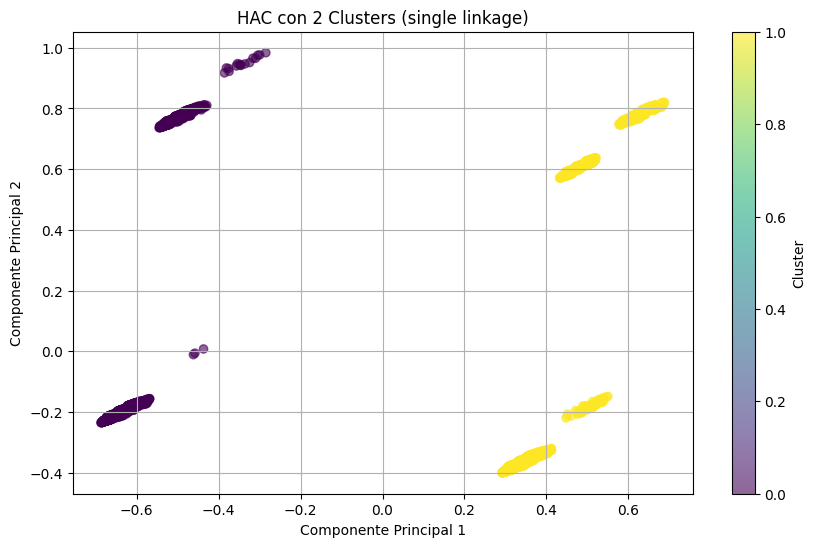

In [20]:
# HAC con 2 clusters y el mismo linkage
model_2 = AgglomerativeClustering(n_clusters=2, linkage='single')
labels_2 = model_2.fit_predict(X_2d)

# Graficar resultado con 2 clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_2, alpha=0.6)
plt.title("HAC con 2 Clusters (single linkage)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

**Respuesta:**

El criterio de vinculación es clave porque define cómo se agrupan los datos, en el caso de single forma clusters conectando puntos cercanos, lo que puede generar estructuras alargadas.

Al comparar los resultados con 2 y 20 clusters usando single, se ve casi lo mismo en la visualización 2D con PCA. Esto probablemente pasa porque al reducir a dos componentes, se pierde información más fina entre los grupos.

Aunque el modelo con 20 clusters puede estar separando bien en más dimensiones, eso no se nota en el gráfico. Por eso es importante considerar también otras formas de visualización o métricas como el Silhouette Score para entender mejor el resultado real.


# Parte 4: DBSCAN y HDBSCAN (15 puntos)

### 4.1.- DBSCAN

Utilizando DBSCAN, itera sobre valores de eps entre 0.25 y 2, con un salto de 0.25 por iteracion. Ademas, itera sobre el numero minimo de muestras, probando con 1, 2, 3 y 4. (3 puntos)

In [24]:
eps_values = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
min_samples_values = [1, 2, 3, 4]

dbscan_clusters = []

for min_samples in min_samples_values:
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        dbscan_clusters.append({'eps': eps, 'min_samples': min_samples,'n_clusters': n_clusters, 'n_noise': n_noise})

for case in dbscan_clusters:
    print(f"eps={case['eps']}, min_samples={case['min_samples']}, clusters={case['n_clusters']}, ruido={case['n_noise']}")

eps=0.25, min_samples=1, clusters=404, ruido=0
eps=0.5, min_samples=1, clusters=66, ruido=0
eps=0.75, min_samples=1, clusters=20, ruido=0
eps=1, min_samples=1, clusters=2, ruido=0
eps=1.25, min_samples=1, clusters=1, ruido=0
eps=1.5, min_samples=1, clusters=1, ruido=0
eps=1.75, min_samples=1, clusters=1, ruido=0
eps=2, min_samples=1, clusters=1, ruido=0
eps=0.25, min_samples=2, clusters=178, ruido=226
eps=0.5, min_samples=2, clusters=31, ruido=35
eps=0.75, min_samples=2, clusters=15, ruido=5
eps=1, min_samples=2, clusters=2, ruido=0
eps=1.25, min_samples=2, clusters=1, ruido=0
eps=1.5, min_samples=2, clusters=1, ruido=0
eps=1.75, min_samples=2, clusters=1, ruido=0
eps=2, min_samples=2, clusters=1, ruido=0
eps=0.25, min_samples=3, clusters=124, ruido=334
eps=0.5, min_samples=3, clusters=24, ruido=49
eps=0.75, min_samples=3, clusters=13, ruido=9
eps=1, min_samples=3, clusters=2, ruido=0
eps=1.25, min_samples=3, clusters=1, ruido=0
eps=1.5, min_samples=3, clusters=1, ruido=0
eps=1.75, min

**RESPUESTA:**

Ejecutamos el código y guardamos los resultados en dbscan_results.

Los resultados almacenados son eps y min_samples que son los parametros que iteramos, luego almacenamos los datos de labes por separado cada uno.


#### 4.1.2 Con la información de los parametros anterior, calcula cual es el número de clusters óptimo para el modelo DBSCAN. (1.5 puntos)

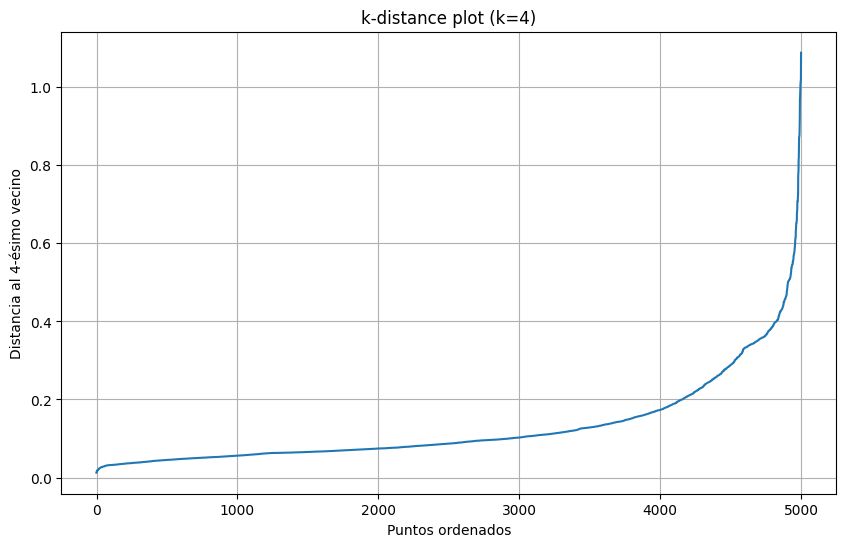

In [ ]:
# min_samples  = 4
k = 4

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.title(f'k-distance plot (k={k})')
plt.xlabel('Puntos ordenados')
plt.ylabel(f'Distancia al {k}-ésimo vecino')
plt.grid(True)
plt.show()

In [ ]:
# el eps estimado por el k-distance plot
eps_kdist = 0.6
min_samples_kdist = 4

dbscan_kdist = DBSCAN(eps=eps_kdist, min_samples=min_samples_kdist)
labels_kdist = dbscan_kdist.fit_predict(X_pca)

n_clusters_kdist = len(set(labels_kdist)) - (1 if -1 in labels_kdist else 0)
n_ruido_kdist = list(labels_kdist).count(-1)

print("Resultado usando eps estimado del k-distance plot:")
print(f"eps = {eps_kdist}, min_samples = {min_samples_kdist}")
print(f"Clusters detectados = {n_clusters_kdist}")
print(f"Puntos de ruido = {n_ruido_kdist}")

Resultado usando eps estimado del k-distance plot:
eps = 0.6, min_samples = 4
Clusters detectados = 11
Puntos de ruido = 31


**RESPUESTA:**

Para estimar el número de clusters óptimo, se utilizó el k-distance plot con k = 4 (correspondiente a min_samples = 4).
En el gráfico se observa un cambio brusco en la pendiente alrededor de eps ≈ 0.6, lo que sugiere que este es un valor adecuado para usar como umbral de densidad en DBSCAN.

#### 4.1.3 Determine tambien el valor optimo del parametro `eps` y `min_samples` (0.5 puntos)

In [32]:
evaluaciones = []

# recorrer todas las combinaciones
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        if n_clusters > 1:
            score = silhouette_score(X_pca, labels)
            evaluaciones.append({'eps': eps, 'min_samples': min_samples, 'n_clusters': n_clusters, 'n_noise': list(labels).count(-1), 'silhouette_score': score})

mejor = max(evaluaciones, key=lambda x: x['silhouette_score'])

print("Mejor combinación de Silhouette Score:")
print(f"eps = {mejor['eps']}")
print(f"min_samples = {mejor['min_samples']}")
print(f"Clusters detectados = {mejor['n_clusters']}")
print(f"Silhouette Score = {mejor['silhouette_score']:.4f}")

Mejor combinación de Silhouette Score:
eps = 0.75
min_samples = 3
Clusters detectados = 13
Silhouette Score = 0.3087


**RESPUESTA:**
Calculamos el maximo de silhouette_score y obtenemos que  el valor optimo de eps es 0.75 y el valor optimo de min_samples es 3.

#### 4.1.4 Obtenga el numero de clusters utilizando los parametros optimos encontrados. Explique por qué podría haber encontrado ese valor, el cual se puede o no ajustar al número de clases en el dataset. (1 puntos)

**RESPUESTA:** Vemos del ejercicio anterior que con los parametros optimos encontrados, el numero de clusters es 13, esto también se puede hacer al entrenar el modelo con los parametros optimos encontrados, a nivel de codigo se ve asi:

In [30]:
dbscan_final = DBSCAN(eps=mejor['eps'], min_samples=mejor['min_samples'])
labels_final = dbscan_final.fit_predict(X_pca)

n_clusters_final = len(set(labels_final)) - (1 if -1 in labels_final else 0)
n_ruido_final = list(labels_final).count(-1)

print("Resultado final con parámetros óptimos:")
print(f"eps = {mejor['eps']}, min_samples = {mejor['min_samples']}")
print(f"Clusters detectados = {n_clusters_final}")
print(f"Puntos de ruido = {n_ruido_final}")

Resultado final con parámetros óptimos:
eps = 0.75, min_samples = 3
Clusters detectados = 13
Puntos de ruido = 9


**RESPUESTA:** En total se detectaron 13 clusters, lo que es distinto a los 11 que se habían obtenido en 4.1.2 usando el eps = 0.6 sugerido por el k-distance plot.
Esta diferencia se da porque el k-distance es solo una referencia visual para estimar el umbral de densidad, mientras que en 4.1.3 usamos Silhouette Score, que evalúa qué tan bien están separados y formados los grupos.

Se espera un analisis de ajuste de datos a clusters contra las clases. Puntaje por analisis y justificacion.

### 4.2.- HDBSCAN

Utilizando HDSCAN, cree un modelo con el `cluster_selection_epsilon` igual al caso de DBSCAN y determine el número de clusters. Itere sobre el min_cluster_size para encontrar el mejor silhoutte score. Compare el resultado con DBSCAN.  (3 puntos)

In [51]:
from hdbscan import HDBSCAN

hdbscan_evaluaciones = []
min_cluster_size = range(2, 20)

for cluster in min_cluster_size:
    hdbscan_model = hdbscan.HDBSCAN(cluster_selection_epsilon=mejor['eps'], min_cluster_size=cluster, metric='euclidean')
    labels = hdbscan_model.fit_predict(X_pca)
    
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_clusters > 1:
        score = silhouette_score(X_pca, labels)
        hdbscan_evaluaciones.append({'min_cluster_size': cluster, 'n_clusters': n_clusters, 'silhouette_score': score})

mejor_hdbscan = max(hdbscan_evaluaciones, key=lambda x: x['silhouette_score'])

print("Mejor combinación de Silhouette Score:")
print(f"min_cluster_size = {mejor_hdbscan['min_cluster_size']}")
print(f"Clusters detectados = {mejor_hdbscan['n_clusters']}")
print(f"Silhouette Score = {mejor_hdbscan['silhouette_score']:.4f}")


/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap

Mejor combinación de Silhouette Score:
min_cluster_size = 6
Clusters detectados = 10
Silhouette Score = 0.3132


**RESPUESTA:**

HDBSCAN detectó 10 clusters optimizando el silhouette score con un min_cluster_size de 6, al comparar con DBSCAN, HDBSCAN tiende a encontrar agrupaciones de manera más natural ya que no requiere fijar eps de forma tan precisa y puede manejar mejor las densidades variadas.

Además HDBSCAN encontró un silhoutte score de 0.3132, mientras que DBSCAN encontró un silhoutte score de 0.3087, lo que hace sentido  porque elimina puntos ruidosos y se concentra en mejores grupos.



#### 4.2.2 Grafique los clusters utilizando PCA de 2 dimensiones. (1 punto)

/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


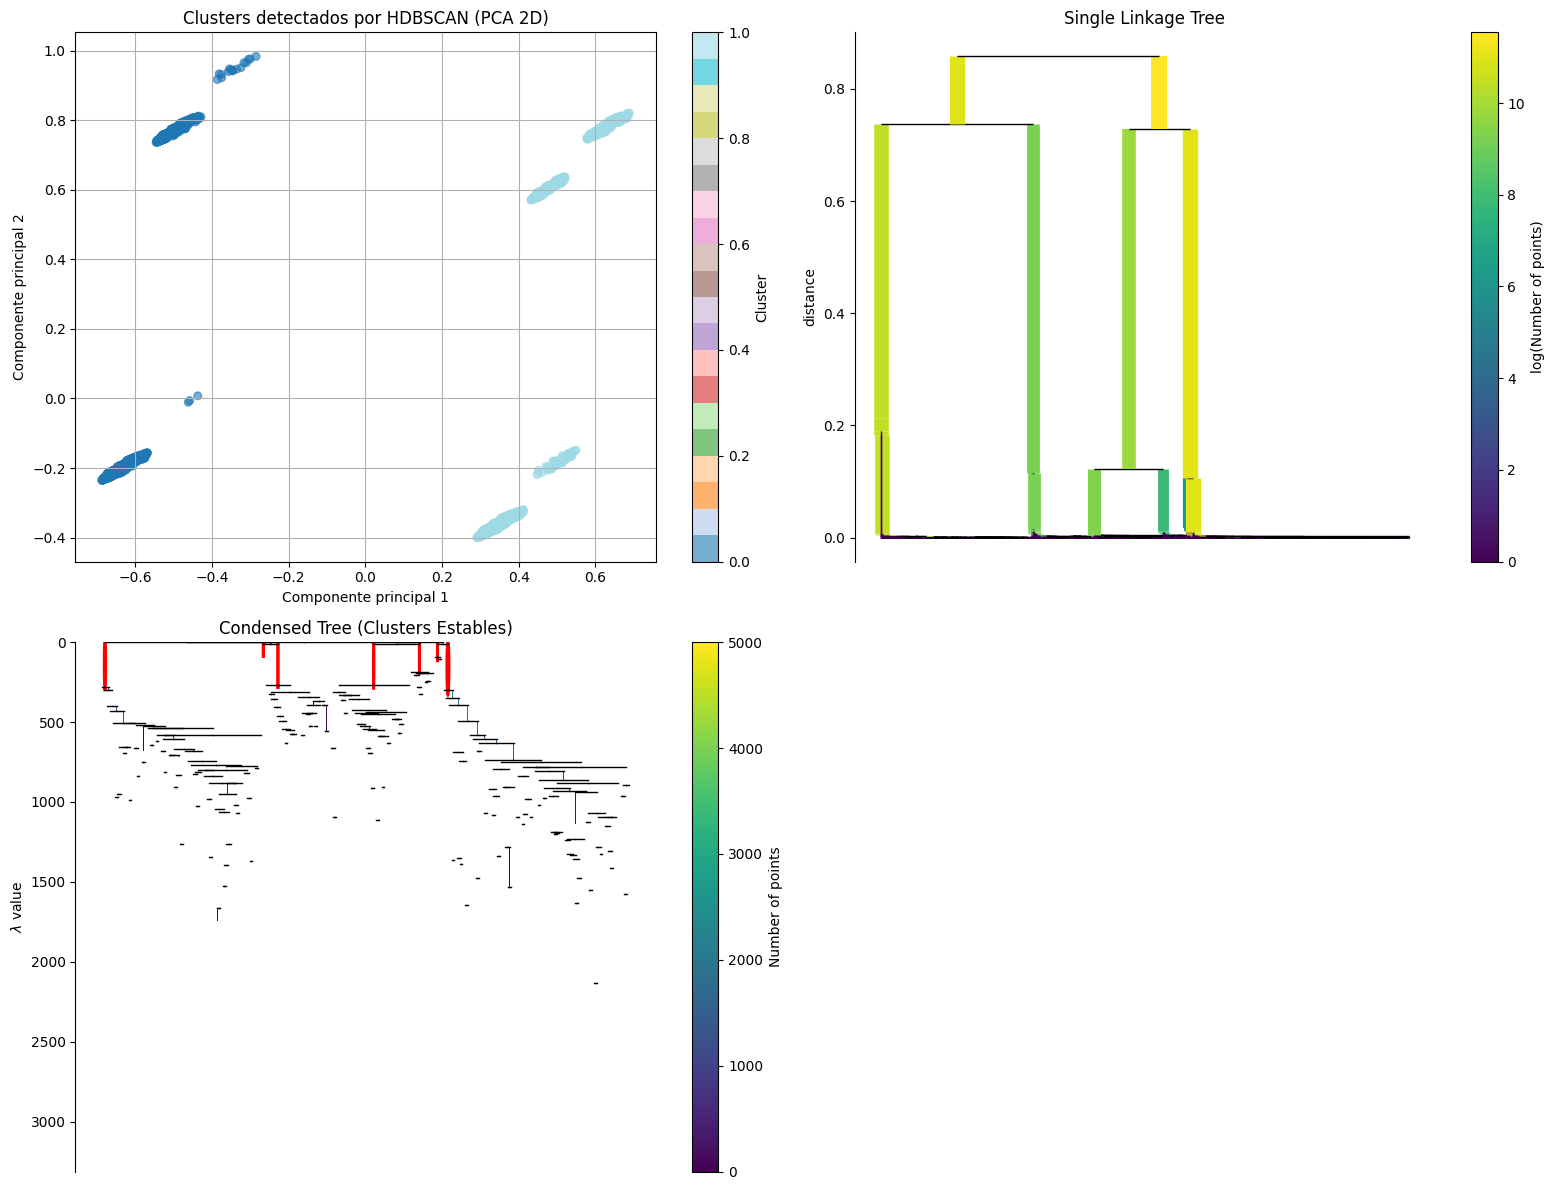

In [59]:
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

hdbscan_model = hdbscan.HDBSCAN(cluster_selection_epsilon=mejor['eps'], min_cluster_size=mejor_hdbscan['min_cluster_size'], metric='euclidean')
labels_hdbscan = hdbscan_model.fit_predict(X_2d)

# Haremos varias graficas para entender el modelo
fig = plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
labels_hdbscan = hdbscan_model.labels_
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_hdbscan, cmap='tab20', alpha=0.6, s=30)
plt.title('Clusters detectados por HDBSCAN (PCA 2D)')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)


plt.subplot(2, 2, 2)
hdbscan_model.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
plt.title('Single Linkage Tree')


plt.subplot(2, 2, 3)
hdbscan_model.condensed_tree_.plot(select_clusters=True, cmap='viridis')
plt.title('Condensed Tree (Clusters Estables)')


plt.tight_layout()
plt.show()

**RESPUESTA:**
Se graficaron los clusters detectados por HDBSCAN proyectados sobre dos componentes principales obtenidas por PCA para tener las 2 dimensiones solicitadas.
Además, se complementó el análisis visualizando el árbol de enlace jerárquico y el árbol condensado, para observar la estructura interna de densidades y la estabilidad de los clusters formados.

¿Que representa cada cluster?

**RESPUESTA:**

Cada cluster representa a un grupo de clientes con caracteristicas similares, al haber aplicado PCA no se puede visualizas específicamente que caracteristicas son las que los agrupan, pero sabemos que representan una suma de factores diferenciadores de cada cliente.

### 4.4 Preguntas teoricas sobre HAC, DBSCAN y HDBSCAN (5 puntos)

#### 4.4.1 En tus palabras, ¿Cómo funciona el Agglomerative Clustering? Además, menciona al menos 2 usos para HAC.

**RESPUESTA:**

El Agglomerative Clustering es un algoritmo de clustering que junta a puntos cercanos en grupos parte considerando cada punto como su propio grupo. Luego, va uniendo los grupos más cercanos según la distancia entre ellos. Geométricamente, es como si se fueran formando zonas y esas áreas se van fusionando a medida que crecen y se acercan a las otras.

A nivel de aplicación, en HAC se puede usar para agrupar clientes en segmentos de comportamiento similar o para agrupar imagenes con caracteristicas similares.

#### 4.4.2 Explique que representa un dendograma, mencionando cómo las ramas principales podrían significar las clases del datset.

**RESPUESTA:**

Un dendograma es una forma de representar la jerarquía de agrupaciones en un conjunto de datos. En este, cada rama es una nueva separación de grupos, y la altura a la que se juntan indica qué tan distintas son entre sí. Las ramas principales representan las clases del dataset, siendo estas las que se separan en el nivel mas alto de la jerarquia, de esta forma las ramas principales son agrupaciones propias del dataset, mientas que las ramas secundarias son agrupaciones que se forman de la union de las ramas principales.

#### 4.4.3 En el contexto del modelo DBSCAN, ¿Que es un core sample? ¿Que podría representar un core sample en términos de un dato en el dataset? Apóyese en la clases y sus características.

**RESPUESTA:**

Un core sample es un punto del dataset que tiene al menos la cantidad indicada en min_samples de vecinos a menos de una distancia eps (radialmente).

De esta forma, entre más cercano sea el dato al centro de esta circunferencia, más será la similitud entre puntos y más perteneciente al grupo formado es.

#### 4.4.4 En el modelo de DBSCAN se iteran sobre distintos parametros; eps y min_samples. ¿Qué representan estos parametros?

**RESPUESTA:**

En este contexto, eps representa la distancia máxima entre puntos para que puedan ser considerados como vecinos del grupo, siempre y cuando se cumpla que existan al menos min_samples puntos en el grupo. De esta forma se entiende eps como distancia máxima de separación entre puntos del grupo y min_samples como la cantidad mínima de puntos que debe haber para considerar un grupo.

#### 4.4.5 ¿Cuál es la diferencia entre DBSCAN y HDBSCAN? ¿Qué beneficios existen de usar un modelo sobre el otro?

**RESPUESTA:**

A nivel de parámetros, DBSCAN toma valores fijos de eps para la distancia máxima, por otra parte, HDBSCAN ajusta los radios de manera automática e iterativa, lo que facilita encontrar clusters de diferentes tamaños y densidades dependiendo de la distribución de los datos, encajando mejor con las distintas realidades y agrupaciones propias del dataset, como la existencias de clusters grandes y pequeños en un mismo conjunto de datos.

# Parte 5: Comparación y eficiencia (3 puntos)

#### 5.1 ¿Cuál de los métodos de clustering resultó ser el más eficiente entre HAC, DBSCAN, HDBSCAN o Isolation Forest? Da una explicación de por qué se puede deber el resultado.

**Respuesta**

Respecto a Isolation Forest, se trata de un modelo para detectar outliers y anomalias en un dataset, por lo que no es un modelo de clustering precisamente.

Luego, al comparar HAC, DBSCAN y HDBSCAN, se puede ver que HDBSCAN es el modelo que mejor funciona ya que al comparar los resultados de silhouette score, HDBSCAN tiene un mejor resultado que los otros dos modelos.

Esto se puede deber a la naturaleza del método y de los datos, donde HDBSCAN es capaz de ajustar sus valores de eps según la densidad y distribución de los datos para encontrar clusters de diferentes tamaños, teniendo esto en cuenta podemos ver que los datos naturalmente son ideales para este caso, ya que al tratarse de datos de personas y caracteristicas de compras, podemos ver que existen acumulaciones de clientes con caracteristicas similares y pequeñas diferencias que deben ser las criterios diferenciadores de cada cliente para la aprobación del credito.






**Referencias**

Se usaron los codigos vistos en clase, documentación oficial y se utilizó Copilot para escritura sistemática del código (en especial gráficos y visualizaciones).